In [16]:
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor

In [17]:
conn = sqlite3.connect('Shared DC2 Group 19\\database_final.db')

query_burg = """SELECT * FROM table_name
WHERE "Crime Type" = "Burglary"
"""
query_sun = """SELECT * FROM sunlight"""
query_house = """SELECT * FROM housing_by_lsoa"""
query_unep = """SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"""

df_burglary_all = pd.read_sql(query_burg, conn)
df_sunlight = pd.read_sql(query_sun, conn)
df_housing = pd.read_sql(query_house, conn)
df_unemployment_all = pd.read_sql(query_unep, conn)
#getting data from dataabse and storing in DF
conn.close()

In [18]:
df_unemployment = df_unemployment_all.rename(columns={'geogcode': 'LSOA code'}) 
df_unemployment['Month'] =  pd.to_datetime(df_unemployment['date'])
df_unemployment_5yr = df_unemployment[(df_unemployment['Month'].dt.year >= 2014) & (df_unemployment['Month'].dt.year <= 2019)]
df_unemployment_5yr = df_unemployment_5yr[df_unemployment_5yr['LSOA code'] != 'Column Total']
df_unemployment_5yr = df_unemployment_5yr.drop(columns=["date", "index"], axis=1)
#filterig unemployment to 5 year time spand of 2014 to 2019 and renaming columns for compatibility 

In [19]:
df_burglary = df_burglary_all.drop(columns=['Reported by', 'Falls within']).dropna()
df_bar=df_burglary[df_burglary['LSOA name'].str.contains('Barnet')]
df_bar['Month'] = pd.to_datetime(df_bar['Month'])
df_bar['Year']= df_bar['Month'].dt.year
#Filtering for Barnet data

C:\Users\shash\AppData\Local\Temp\ipykernel_2032\222152881.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bar['Month'] = pd.to_datetime(df_bar['Month'])
C:\Users\shash\AppData\Local\Temp\ipykernel_2032\222152881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bar['Year']= df_bar['Month'].dt.year


In [20]:
df_sunlight['Month'] = pd.to_datetime(df_sunlight['Year-Month'])
df_sunlight=df_sunlight.drop(columns=["Year-Month", "index"], axis=1)
#Sunlight DF, ensuring compatibility by creating Datime Col

In [21]:
df_housing = df_housing.drop(columns=["index"], axis=1)
#Houding dataframe

In [22]:
burglaries_per_lsoa_month = df_bar[df_bar['Crime type'] == 'Burglary'].groupby(['LSOA code', 'Month']).size()
burglaries_per_lsoa_month = burglaries_per_lsoa_month.reset_index(name='Total Burglaries')
#Getting total burglaries per LSOA on a Monthly basis
#burglaries_per_lsoa_month["Total Burglaries"].unique()

In [23]:
temp_merged = burglaries_per_lsoa_month.merge(df_housing, how='left', on=['LSOA code']).dropna() #Merging Berg and Housing
df_merged = temp_merged.merge(df_sunlight, how='left', on=['Month']) #Merging sunlight and (Housing+Burg)
df_merged_2 =  df_merged.merge(df_unemployment_5yr, how='left', on=['Month', 'LSOA code']) #Mergving pervious with unemployment
temp_merged_clean = df_merged_2.drop(columns=['Missing', 'LSOA name']) #Drop unnecessary Cols

# Create dummy variables for the 'LSOA code' column
dummy_df = pd.get_dummies(temp_merged_clean['LSOA code'], prefix='LSOA')

# Concatenate the dummy variables with the original DF
df_temp_merged_clean_dummies = pd.concat([temp_merged_clean, dummy_df], axis=1)
df_temp_merged_clean_dummies['Month_Int'] = df_temp_merged_clean_dummies['Month'].dt.month #Creating month int col
df_temp_merged_clean_dummies.head()


,LSOA code,Month,Total Burglaries,Owned or shared ownership,Private Rented or lives rent free,Social Rented,Proportion social,Proportion rented,Detached whole house or bungalow,Semi-detached whole house or bungalow,...,LSOA_E01000316,LSOA_E01000317,LSOA_E01000318,LSOA_E01000319,LSOA_E01000320,LSOA_E01000321,LSOA_E01000322,LSOA_E01000323,LSOA_E01000324,Month_Int
0,E01000115,2011-01-01,2,435.0,45.0,0.0,0.0,0.09375,135.0,335.0,...,0,0,0,0,0,0,0,0,0,1
1,E01000115,2011-04-01,1,435.0,45.0,0.0,0.0,0.09375,135.0,335.0,...,0,0,0,0,0,0,0,0,0,4
2,E01000115,2011-08-01,1,435.0,45.0,0.0,0.0,0.09375,135.0,335.0,...,0,0,0,0,0,0,0,0,0,8
3,E01000115,2011-12-01,4,435.0,45.0,0.0,0.0,0.09375,135.0,335.0,...,0,0,0,0,0,0,0,0,0,12
4,E01000115,2012-01-01,2,435.0,45.0,0.0,0.0,0.09375,135.0,335.0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
df_temp_merged_clean_train = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year >= 2014) & (df_temp_merged_clean_dummies['Month'].dt.year <= 2018)]
df_temp_merged_clean_test = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year == 2019)] 
#Filtering test and train based on time span of 2014 to 2018 for Train and 2019 for Test

In [25]:

#X_train = df_temp_merged_clean_train.drop(columns=["Total Burglaries", "Month", "LSOA code"], axis = 1)
X_train = df_temp_merged_clean_train[["Proportion social", "Proportion rented", "Month_Int", "Sunlight", "value"]] #What you give to the model
y_train = df_temp_merged_clean_train["Total Burglaries"] #What needs to be predicted
#X_test = df_temp_merged_clean_test.drop(columns=["Total Burglaries", "Month", "LSOA code"], axis = 1)
X_test = df_temp_merged_clean_test[["Proportion social", "Proportion rented", "Month_Int", "Sunlight", "value"]] #What you give to the model
y_test = df_temp_merged_clean_test["Total Burglaries"] #Waht needs to be predicted

In [26]:
model = XGBRegressor()
model.fit(X_train, y_train)
#Fitting data to model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

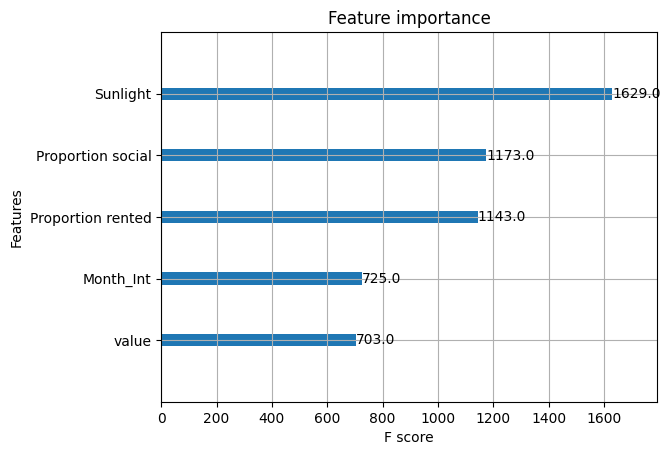

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
xgb.plot_importance(model, ax=plt.gca(), max_num_features=15)
#Plotting the most important featurs

In [28]:
pred_train = model.predict(X_train)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
predictions = model.predict(X_test)

In [29]:
#Train performance 
print("MSE Test " + str(mean_squared_error(y_train, pred_train)) + "  MAE test " + str(mean_absolute_error(y_train, pred_train)) + "  R^2 " + str(r2_score(y_train, pred_train)))


MSE Test 0.8154558276706723  MAE test 0.669473992164964  R^2 0.5601021566168595


In [30]:
#Test performance   
print("MSE Test " + str(mean_squared_error(y_test, predictions)) + "  MAE test " + str(mean_absolute_error(y_test, predictions)) + "  R^2 " + str(r2_score(y_test, predictions)))

MSE Test 1.9885187935456319  MAE test 1.0262345899975174  R^2 -0.17103766619739313
